In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

import seaborn as sns
import matplotlib.pyplot as plt

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
def set_plot_style():
    # Define the custom color palette
    custom_palette = [
        '#5F9EA0', # cadet blue
        '#FFD700', # gold
        '#FFA07A', # light salmon
        '#87CEEB', # light blue
        '#9370DB', # medium purple
        '#98FB98'  # pale green
    ]
    
    # Set the Seaborn palette
    sns.set_palette(custom_palette)
    
    # Set general plot aesthetics
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    # Update Matplotlib rcParams for consistent styling
    plt.rcParams.update({
        'figure.figsize': (12, 7),
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.title_fontsize': 13,
        'legend.fontsize': 11,
        'axes.titlepad': 20,
        'axes.labelpad': 10,
        'xtick.major.pad': 5,
        'ytick.major.pad': 5
    })

In [27]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)

# Experiment 0: Assessing Catastrophic Forgetting

In [28]:
path_to_hnets = './Models/Models_HNET'
experiment0_hnet = 'Experiment76'
models_exp0_hnet = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet)))


path_results = './Results/' + experiment0_hnet
with open(os.path.join(path_results +'.pkl'), 'rb') as fp:
    results_hnet_exp0 = pickle.load(fp)

data_path_exp0 = './Data/Sim_Data_'+'Experiment60_sorted'+'.pkl'
with open(os.path.join(data_path_exp0), 'rb') as fp:
    data_exp0 = pickle.load(fp)

In [29]:
def true_task_dict(data):
    max_id = 0
    found_ids = []
    true_task_map = {}
    for d in data.keys():
        new_id = d.split('_')[1]
        if new_id not in found_ids:
            found_ids.append(new_id)
            true_task_map[d] = max_id
            max_id += 1
        else:
            idx_id = found_ids.index(new_id)
            true_task_map[d] = idx_id

    return true_task_map

In [30]:
def build_result_df(results, data):
    dataset = []
    r2_test_detector = []
    r2_test_hnet = []
    y_true_detector = []
    y_pred_detector = []
    y_true_hnet = []
    y_pred_hnet = []
    predicted_task = []
    new_task = [] 
    true_task = []
    train_loss = []
    val_loss = []


    true_task_map = true_task_dict(data)

    for set in results.keys():
        dataset.append(set)
        r2_test_detector.append(results[set]['r2_test_detector'])
        r2_test_hnet.append(results[set]['r2_test_hnet'])
        predicted_task.append(results[set]['predicted_task'])
        new_task.append(results[set]['new_task'])
        true_task.append(true_task_map[set])
        if 'y_true_hnet' in results[set].keys():
            y_true_hnet.append([results[set]['y_true_hnet']])
            y_pred_hnet.append([results[set]['y_pred_hnet']])
            
        else:
            y_true_hnet.append([0])
            y_pred_hnet.append([0])
            
        if 'y_true_detector' in results[set].keys():
            y_true_detector.append([results[set]['y_true_detector']])
            y_pred_detector.append([results[set]['y_pred_detector']])
            train_loss.append([results[set]['hnet_train_losses']])
            val_loss.append([results[set]['hnet_val_losses']])
        else:
            y_true_detector.append([0])
            y_pred_detector.append([0])
            train_loss.append([0])
            val_loss.append([0])

    df = pd.DataFrame({'Dataset':dataset,
                   'True_Task': true_task,
                   'Predicted_Task' : predicted_task,
                   'New_Task': new_task, 
                    'Y_t_detector': y_true_detector,
                    'Y_p_detector':y_pred_detector,  
                    'R2_Detector':r2_test_detector,
                    'Y_t_hnet': y_true_hnet,
                    'Y_p_hnet':y_pred_hnet,  
                    'R2_hnet':r2_test_hnet, 
                    'HNET_training_loss': train_loss,
                    'HNET_val_loss': val_loss})
    return df

In [31]:
def build_catas_forg_df(results, data, models, experiment_name):
    model = []
    test_set = []
    r2_list = []
    data_name = []

    df  = build_result_df(results, data)
    
    for i,m in enumerate(models):
        model_i = torch.load(os.path.join(path_to_hnets,experiment_name, m))
        for task,set in zip(df.True_Task, df.Dataset):
            perturbed_task = set.split('_')[1]

            if perturbed_task == '0':
                name = 'Baseline'
            elif perturbed_task == '1':
                name = 'Removed Neurons'    
            elif perturbed_task == '2':
                name = 'Shuffled Neurons'
            elif perturbed_task == '3':
                name = 'Gain' 
            elif perturbed_task == '4':
                name = 'Offset'

            pred_task = df.loc[df.Dataset == set].Predicted_Task.values
                
            if int(pred_task) <= i :
                W = model_i(cond_id = int(pred_task))
                main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  hidden_size = 300,
                                    num_layers= 1,out_dims=2,  
                                    dropout= 0.2,  LSTM_ = False)
                x_train, y_train, x_val, y_val, x_test, y_test = data[set]
                r2, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
                model.append(m)
                test_set.append(set)
                r2_list.append(r2)
                data_name.append(name)    

    df_plot = pd.DataFrame({ 'Model':model,
                        'Name' : data_name,
                        'Dataset':test_set,
                        'R2': r2_list})
    return df_plot

In [32]:


def plot_catas_forg(df_plot):
    set_plot_style()
    # Create the bar plot
    plt.figure()

    sns.barplot(data=df_plot, x='Model', y='R2', hue='Name')#, palette=custom_palette,)#, color = 'Name', ci=None)  # ci=None to remove confidence intervals

    plt.title('R2 Value by Model and Dataset during CL with Hypernetworks', fontsize=20)

    plt.xlabel('Model')

    plt.ylabel('R2 Value')

    new_labels = ['Trained Task 1', 'Trained Task 2', 'Trained Task 3', 'Trained Task 4', 'Trained Task 5']  # New labels for x-axis

    plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
    plt.yticks(fontsize = 12)
    plt.legend(title='Dataset', bbox_to_anchor=(1.05, 0.75), loc='upper left')
    plt.tight_layout()
    plt.ylim([0.5,0.9])
    plt.show()

In [33]:
df = build_catas_forg_df(results_hnet_exp0, data_exp0, models_exp0_hnet, experiment0_hnet)

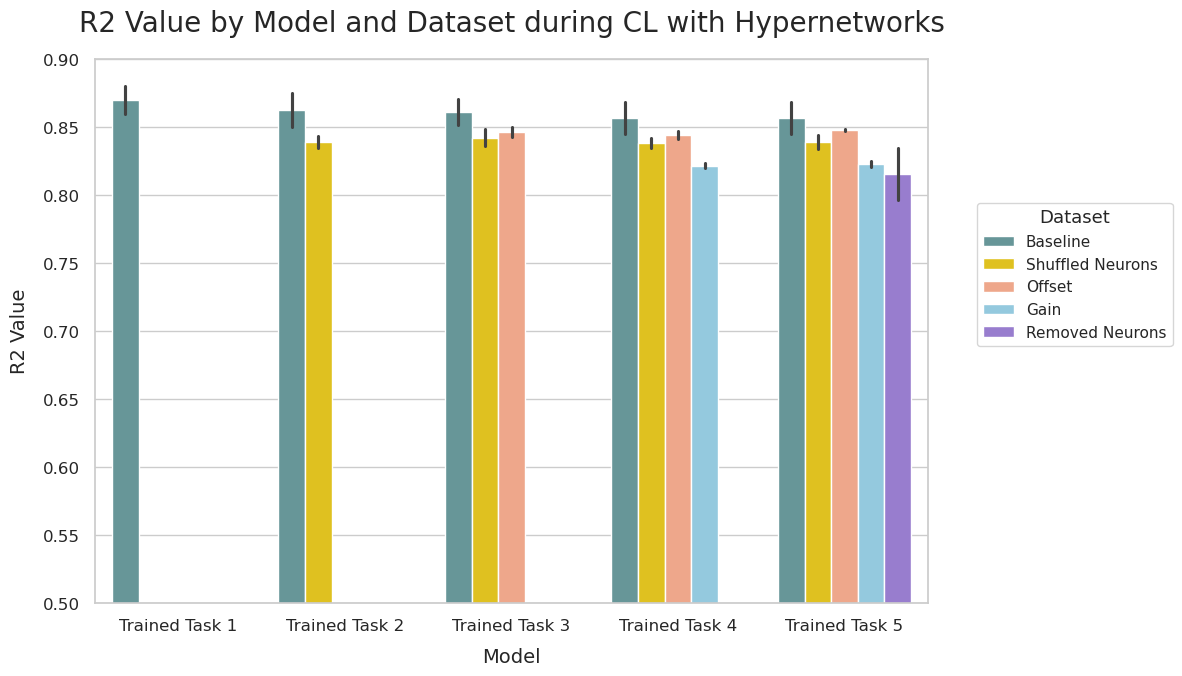

In [34]:
plot_catas_forg(df)

# Experiment 1: Comparison with other methods

# Experiment 2: Task order effect

# Experiment 3: Determining the minimum trial number to learn and identify tasks